# Demonstrates use of CNN with Time Series

## Initialize

In [11]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
import torch, torchvision
import os
import matplotlib.pyplot as plt, numpy as np,  pandas as pd

root_notebook_folder = os.path.abspath('.')
data_folder = os.path.abspath('./local_data')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Demonstrate the data

In [13]:
data_file_name = os.path.join(data_folder, 'ER admission_1.csv')
raw_data = pd.read_csv(data_file_name)
raw_data['t'] = pd.to_datetime(raw_data['t'])
raw_data = raw_data.reset_index(drop=True).set_index('t')
raw_data.head()

,n
t,
2004-01-01 00:00:00,5
2004-01-01 01:00:00,8
2004-01-01 02:00:00,8
2004-01-01 03:00:00,8
2004-01-01 04:00:00,0


## Custom Dataset Class

<img src="lstm_data_arrangement.png"></img>

In [14]:
class TimeSeriesDataSet(torch.utils.data.Dataset):   
    def __init__(self, data_folder, history_samples, horizon_samples):
        import pandas as pd, os, torch
        super(TimeSeriesDataSet).__init__() # call parent class constructor. 

        
        self.data_folder = data_folder
        self.history_samples = history_samples
        self.horizon_samples = horizon_samples
        
        self.df = pd.read_csv( os.path.join(self.data_folder, 'ER admission_1.csv'))
        self.df['t'] = pd.to_datetime(self.df['t'])
        self.df = self.df.reset_index(drop=True).set_index('t')

    def __len__(self):
        return len(self.df) - self.history_samples - self.horizon_samples + 1

    def __getitem__(self, idx):
        import torch
        if idx >= self.__len__():
            raise  IndexError(f'Index out of range: {idx} out of {self.__len__()}')
        x = torch.FloatTensor(self.df.iloc[idx:idx+ self.history_samples]['n'].values)
        y = torch.FloatTensor(self.df.iloc[idx+ self.history_samples : idx+self.history_samples + self.horizon_samples]['n'].values)
        return (x.view(1, -1), y) # number of channels, number of samples

### Load the data

In [15]:
all_data = TimeSeriesDataSet(data_folder,
                history_samples=24*14, 
                horizon_samples=24*3)

- X dimensions:  history size to learn from (14 days) x number of channels (1)
- Y dimensions:  number of samples to predict  x 1 (number of channels)

### split into train and test sets. 

In [16]:
train_set = torch.utils.data.Subset(all_data, list(range(int(len(all_data)*0.9))))
test_set = torch.utils.data.Subset(all_data, list(range(int(len(all_data)*0.9)+all_data.history_samples+all_data.horizon_samples, len(all_data))))

print(f'Data set: {len(all_data)}. history size: {all_data.history_samples}. Prediction window size: {all_data.horizon_samples} ')
print(f"Train set: {len(train_set)}: from {train_set.indices[0]} to: {train_set.indices[-1]}")
print(f"Test set: {len(test_set)}: from {test_set.indices[0]} to: {test_set.indices[-1]}")
print(f"sample size: x: {train_set[0][0].shape}, y: {train_set[0][1].shape}")

Data set: 33913. history size: 336. Prediction window size: 72 
Train set: 30521: from 0 to: 30520
Test set: 2984: from 30929 to: 33912
sample size: x: torch.Size([1, 336]), y: torch.Size([72])


### Train & apply scaler to train set, apply only to test set

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
# train scaler on the train set: 0 to len(train_set) + history_samples + horizon_samples
scaler.fit(all_data.df['n'].iloc[:len(train_set)+all_data.history_samples+all_data.horizon_samples].values.reshape(-1,1))
all_data.df[:] = scaler.transform(all_data.df)
print(f"min-max: {all_data.df['n'].min()} - {all_data.df['n'].max()}")

min-max: 0.0 - 1.0


In [18]:
X,y = train_set[0]
X.shape, y.shape

(torch.Size([1, 336]), torch.Size([72]))

### Demonstrate use of 1d convolution

In [19]:
x = torch.rand(10, 1, 20) # batch x channels x samples
torch.nn.Conv1d(1, 9, kernel_size=5)(x).shape # batch x channels x samples

torch.Size([10, 9, 16])

## Define and train the model

### Define the network class

In [20]:
class CNNModel1(torch.nn.Module):
    def __init__(self, window_size,  input_dim, output_dim):
        super(CNNModel1, self).__init__()
        self.window_size  = window_size # number of samples to train from. 
        self.input_dim = input_dim # number of features in the input. 
        self.output_dim = output_dim # number of features to predict. 

        # Define the LSTM layer
        self.conv1 = torch.nn.Conv1d(self.input_dim, 25, kernel_size=21, padding=10)
        self.relu1 = torch.nn.ReLU()

        # Define the dense layers. 
        self.fc1 = torch.nn.Linear(25*self.window_size , 100)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(100, self.output_dim)

    def forward(self, x):
        #x shape: batch_size x input_dim (number of features) x window_size
        if x.ndim == 2: 
            x = x.unsqueeze(0)
        batch_size = x.shape[0] # first dimension of the input is the number of batches. 
        #print(x.shape)
        x = self.relu1(self.conv1(x))        
        
        #print(x.shape)
        x = x.view(batch_size, -1) # result size; batch_size x input_dim * number of features * window_size
        #print(x.shape)
        x = self.relu1(self.fc1(x))
        x = self.fc2(x)
        return x

### Demonstrate use of the model
Used to confirm that the model can indeed run with the given data

In [21]:
model = CNNModel1(window_size=all_data.history_samples,  input_dim=1, output_dim=all_data.horizon_samples)
model(all_data[0][0]).shape

torch.Size([1, 72])

### Load & scale the data 

In [22]:
all_data = TimeSeriesDataSet(data_folder,
                history_samples=24*14, 
                horizon_samples=24*3)
# split into train and test set
train_dataset = torch.utils.data.Subset(all_data, list(range(int(len(all_data)*0.9))))
test_dataset = torch.utils.data.Subset(all_data, list(range(int(len(all_data)*0.9)+all_data.history_samples+all_data.horizon_samples, len(all_data))))
# normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
# train scaler on the train set: 0 to len(train_set) + history_samples + horizon_samples
scaler.fit(all_data.df['n'].iloc[:len(train_dataset)+all_data.history_samples+all_data.horizon_samples].values.reshape(-1,1))
all_data.df[:] = scaler.transform(all_data.df)

#### Iterate over batches

In [23]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=3, shuffle=True, drop_last=False)    
x, y = next(iter(train_loader))
x.shape, model(x).shape, y.shape

(torch.Size([3, 1, 336]), torch.Size([3, 72]), torch.Size([3, 72]))

### Define method to compute model Accuracy

In [24]:
def model_accuracy(model, data_loader):  
    device = next(model.parameters()).device # get device on which the model is loaded. 
    model.eval() # must set model to evaluation mode to disable dropout!
    with torch.no_grad():
        current_mse, samples_counts = 0, 0
        for X, y in data_loader: 
            X, y = X.to(device=device), y.to(device=device)
            y_pred = model(X)
            current_mse += torch.nn.MSELoss()(y_pred, y)*len(y)
            samples_counts += len(y)
        return current_mse/samples_counts

In [25]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2000, shuffle=True, drop_last=False)    
model = CNNModel1(window_size=all_data.history_samples,  input_dim=1, output_dim=all_data.horizon_samples)
model.to(device)
model_accuracy(model,train_loader)

tensor(0.1024, device='cuda:0')

In [26]:
def training_loop(model, optimizer, criterion, device, train_dataset, validation_dataset, n_epochs = 50, batch_size = 20, checkpoint_file_name = None):  
    import os, time
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)    
    validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=False) if validation_dataset is not None else None

    if (checkpoint_file_name is not None) and (os.path.isfile(checkpoint_file_name)): # checkpoint found!         
        checkpoint_data = torch.load(checkpoint_file_name)
        
        first_epoch = checkpoint_data['epoch']+1 # +1 continue from the following epoch        
        model.load_state_dict(checkpoint_data['model_state_dict'])
        optimizer.load_state_dict(checkpoint_data['optimizer_state_dict'])
        progress_log = checkpoint_data['progress_log']        
    else:
        first_epoch = 0
        progress_log = []
        
    model.to(device)
    
    torch.autograd.set_detect_anomaly(True)
    for epoch in range(first_epoch, n_epochs):
        epoch_start_time = time.time()
        model.train() # set model into train mode. 
        
        current_loss = 0

        for train_data, train_data_labels in train_loader:
            train_data, train_data_labels = train_data.to(device=device), train_data_labels.to(device=device) # move train data to device. 

            optimizer.zero_grad() # clear gradients of all model parameters. 
            output = model(train_data) # forward pass: compute model predictions
            loss = criterion(output, train_data_labels) # calculate the current loss
            loss.backward(retain_graph=True) # backward pass: compute gradient of the loss for all model parameters. 
            optimizer.step() # use gradients to update the model parameters 

            current_loss += loss.item() * len(train_data) # weight loss by the size of the batch. 
        # evaluate performance of the batch: torch.no_grad() is not required since it's called in the model_accuracy function.     

        train_accuracy = model_accuracy(model, train_loader)
        validate_accuracy = model_accuracy(model, validation_loader) if validation_loader is not None else -1
        print(f"{epoch} of {n_epochs}. time={time.time()-epoch_start_time:0.2f}sec. Loss: {current_loss/ len(train_loader.dataset):0.4f}.Train accuracy: {train_accuracy:0.4f}. Validate accuracy: {validate_accuracy:0.4f}")
        progress_log.append({'epoch':epoch,'epoch_start_time':time.time()-epoch_start_time, 'loss':current_loss/ len(train_loader.dataset), 'train_accuracy':train_accuracy, 'validate_accuracy':validate_accuracy })

        # save checkpoint: 
        if checkpoint_file_name is not None:
            checkpoint_data  = {
                'epoch' : epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'progress_log' : progress_log
            }
            torch.save(checkpoint_data, checkpoint_file_name)
    model.eval();
    return model, progress_log

To clear GPU Memory: 
<code>
import gc
del model
del optimizer
gc.collect()
torch.cuda.empty_cache()
</code>

In [27]:
checkpoint_file_name = os.path.join(data_folder, 'ER Admission - CNN -1.checkpoint.pt' )
n_epochs = 15
batch_size = 2000

model = CNNModel1(window_size=all_data.history_samples,  input_dim=1, output_dim=all_data.horizon_samples)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)


model, progress_log = training_loop(model, optimizer, criterion, device, train_dataset, validation_dataset=None, 
                    n_epochs = n_epochs, batch_size = batch_size, 
                    checkpoint_file_name=checkpoint_file_name) 

0 of 15. time=18.15sec. Loss: 1.3975.Train accuracy: 0.0443. Validate accuracy: -1.0000
1 of 15. time=19.09sec. Loss: 0.0312.Train accuracy: 0.0272. Validate accuracy: -1.0000
2 of 15. time=18.14sec. Loss: 0.0261.Train accuracy: 0.0251. Validate accuracy: -1.0000
3 of 15. time=17.93sec. Loss: 0.0244.Train accuracy: 0.0237. Validate accuracy: -1.0000
4 of 15. time=18.04sec. Loss: 0.0233.Train accuracy: 0.0229. Validate accuracy: -1.0000
5 of 15. time=18.07sec. Loss: 0.0226.Train accuracy: 0.0223. Validate accuracy: -1.0000
6 of 15. time=18.07sec. Loss: 0.0221.Train accuracy: 0.0219. Validate accuracy: -1.0000
7 of 15. time=18.35sec. Loss: 0.0218.Train accuracy: 0.0217. Validate accuracy: -1.0000
8 of 15. time=18.63sec. Loss: 0.0217.Train accuracy: 0.0217. Validate accuracy: -1.0000
9 of 15. time=23.18sec. Loss: 0.0216.Train accuracy: 0.0216. Validate accuracy: -1.0000
10 of 15. time=21.52sec. Loss: 0.0216.Train accuracy: 0.0216. Validate accuracy: -1.0000
11 of 15. time=20.66sec. Loss: 

In [28]:
for log_entry in progress_log: 
    print(f"{log_entry['epoch']} of {len(progress_log)}. Loss: {log_entry['loss']:0.4f}.Train accuracy: {log_entry['train_accuracy'].item():0.4f}.")

0 of 15. Loss: 1.3975.Train accuracy: 0.0443.
1 of 15. Loss: 0.0312.Train accuracy: 0.0272.
2 of 15. Loss: 0.0261.Train accuracy: 0.0251.
3 of 15. Loss: 0.0244.Train accuracy: 0.0237.
4 of 15. Loss: 0.0233.Train accuracy: 0.0229.
5 of 15. Loss: 0.0226.Train accuracy: 0.0223.
6 of 15. Loss: 0.0221.Train accuracy: 0.0219.
7 of 15. Loss: 0.0218.Train accuracy: 0.0217.
8 of 15. Loss: 0.0217.Train accuracy: 0.0217.
9 of 15. Loss: 0.0216.Train accuracy: 0.0216.
10 of 15. Loss: 0.0216.Train accuracy: 0.0216.
11 of 15. Loss: 0.0216.Train accuracy: 0.0216.
12 of 15. Loss: 0.0216.Train accuracy: 0.0216.
13 of 15. Loss: 0.0216.Train accuracy: 0.0216.
14 of 15. Loss: 0.0216.Train accuracy: 0.0216.


## Define and train CNN with Batch normalization, Max pooling and Dropout

### Define the model

In [30]:
class CNNModel1a(torch.nn.Module):
    def __init__(self, window_size,  input_dim, output_dim):
        super(CNNModel1a, self).__init__()
        self.window_size  = window_size # number of samples to train from. 
        self.input_dim = input_dim # number of features in the input. 
        self.output_dim = output_dim # number of features to predict. 

        # Define the Conv1 layer
        # batch_size x input_dim  x  336 -> batch_size x 25 x  336
        self.conv1 = torch.nn.Conv1d(self.input_dim, 25, kernel_size=9, padding=4)
        self.relu1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm1d(25)
        # batch_size x 25 x  336 -> batch_size x 25 x  336/2
        self.maxpool1 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = torch.nn.Dropout(0.3)
        
        # batch_size x 25 x  336/2 -> batch_size x 20 x  336/2=84
        self.conv2 = torch.nn.Conv1d( 25, 20, kernel_size=9, padding=4)
        self.relu2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm1d(20)
        
        # batch_size x 25 x  336/2 -> batch_size x 20 x  336/4=84
        self.maxpool2 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout2 = torch.nn.Dropout(0.3)
        

        # Define the dense layers. 
        self.fc1 = torch.nn.Linear(20*int(self.window_size/4) , 100)
        self.relu_fc1 = torch.nn.ReLU()
        self.bn_fc1 = torch.nn.BatchNorm1d(100)
        self.fc2 = torch.nn.Linear(100, self.output_dim)

    def forward(self, x):
        #x shape: batch_size x input_dim x window_size
        if x.ndim == 2: 
            x = x.unsqueeze(0)
        batch_size = x.shape[0] # first dimension of the input is the number of batches. 
        #print(x.shape)
        x = self.relu1(self.conv1(x))     
        #print(x.shape)
        x = self.dropout1(self.maxpool1(x))
        x = self.bn1(x)
        #print(x.shape)
        x = self.relu2(self.conv2(x))     
        x = self.dropout2(self.maxpool2(x))
        x = self.bn2(x)
        #print(x.shape)
        x = x.view(batch_size, -1) # result size; batch_size x input_dim * number of features * window_size
        #print(x.shape)
        x = self.bn_fc1(self.relu_fc1(self.fc1(x)))
        x = self.fc2(x)
        return x

### Test the model mechanics

In [31]:
model = CNNModel1a(window_size=all_data.history_samples,  input_dim=1, output_dim=all_data.horizon_samples)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=3, shuffle=True, drop_last=False)    
x, y = next(iter(train_loader))
x.shape, model(x).shape, y.shape

(torch.Size([3, 1, 336]), torch.Size([3, 72]), torch.Size([3, 72]))

In [32]:
checkpoint_file_name = os.path.join(data_folder, 'ER Admission - CNN -1a.checkpoint.pt' )
n_epochs = 15
batch_size = 2000

model = CNNModel1a(window_size=all_data.history_samples,  input_dim=1, output_dim=all_data.horizon_samples)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)


model, progress_log = training_loop(model, optimizer, criterion, device, train_dataset, validation_dataset=None, 
                    n_epochs = n_epochs, batch_size = batch_size, 
                    checkpoint_file_name=checkpoint_file_name) 

0 of 15. time=20.71sec. Loss: 0.1264.Train accuracy: 0.0193. Validate accuracy: -1.0000
1 of 15. time=20.11sec. Loss: 0.0182.Train accuracy: 0.0139. Validate accuracy: -1.0000
2 of 15. time=20.11sec. Loss: 0.0110.Train accuracy: 0.0095. Validate accuracy: -1.0000
3 of 15. time=19.07sec. Loss: 0.0093.Train accuracy: 0.0087. Validate accuracy: -1.0000
4 of 15. time=19.11sec. Loss: 0.0088.Train accuracy: 0.0082. Validate accuracy: -1.0000
5 of 15. time=19.10sec. Loss: 0.0085.Train accuracy: 0.0079. Validate accuracy: -1.0000
6 of 15. time=20.02sec. Loss: 0.0083.Train accuracy: 0.0077. Validate accuracy: -1.0000
7 of 15. time=19.10sec. Loss: 0.0081.Train accuracy: 0.0075. Validate accuracy: -1.0000
8 of 15. time=19.05sec. Loss: 0.0079.Train accuracy: 0.0074. Validate accuracy: -1.0000
9 of 15. time=19.89sec. Loss: 0.0078.Train accuracy: 0.0073. Validate accuracy: -1.0000
10 of 15. time=20.63sec. Loss: 0.0077.Train accuracy: 0.0072. Validate accuracy: -1.0000
11 of 15. time=21.31sec. Loss: 

In [33]:
for log_entry in progress_log: 
    print(f"{log_entry['epoch']} of {len(progress_log)}. Loss: {log_entry['loss']:0.4f}.Train accuracy: {log_entry['train_accuracy'].item():0.4f}.")

0 of 15. Loss: 0.1264.Train accuracy: 0.0193.
1 of 15. Loss: 0.0182.Train accuracy: 0.0139.
2 of 15. Loss: 0.0110.Train accuracy: 0.0095.
3 of 15. Loss: 0.0093.Train accuracy: 0.0087.
4 of 15. Loss: 0.0088.Train accuracy: 0.0082.
5 of 15. Loss: 0.0085.Train accuracy: 0.0079.
6 of 15. Loss: 0.0083.Train accuracy: 0.0077.
7 of 15. Loss: 0.0081.Train accuracy: 0.0075.
8 of 15. Loss: 0.0079.Train accuracy: 0.0074.
9 of 15. Loss: 0.0078.Train accuracy: 0.0073.
10 of 15. Loss: 0.0077.Train accuracy: 0.0072.
11 of 15. Loss: 0.0076.Train accuracy: 0.0072.
12 of 15. Loss: 0.0075.Train accuracy: 0.0071.
13 of 15. Loss: 0.0075.Train accuracy: 0.0070.
14 of 15. Loss: 0.0074.Train accuracy: 0.0070.


### Explore the model

#### Compute average accuracy

In [34]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2000, shuffle=False, drop_last=False)    
test_accuracy = model_accuracy(model, test_loader).item()
print(f"test accuracy: {test_accuracy}")

test accuracy: 0.007044543977826834


#### Plot model convergence 

In [35]:
import pandas as pd
log_data = pd.DataFrame(progress_log)
log_data['train_accuracy'] = log_data['train_accuracy'].apply(lambda x: x.item())
log_data.head()

,epoch,epoch_start_time,loss,train_accuracy,validate_accuracy
0,0,20.723027,0.126430,0.019331,-1
1,1,20.131949,0.018246,0.013946,-1
2,2,20.124948,0.011050,0.009498,-1
3,3,19.087648,0.009336,0.008680,-1
4,4,19.124015,0.008821,0.008177,-1


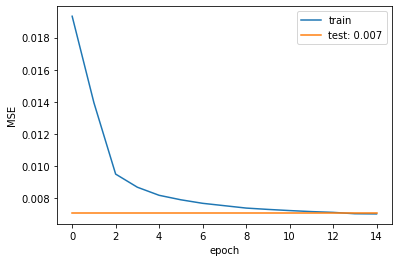

In [36]:
plt.figure()
plt.plot(log_data.epoch, log_data.train_accuracy, label='train')
plt.plot(log_data.epoch, test_accuracy*np.ones(log_data.epoch.shape), label=f'test: {test_accuracy:3.3f}')
plt.legend(); plt.xlabel('epoch'); plt.ylabel('MSE');

#### Prediction of the first point

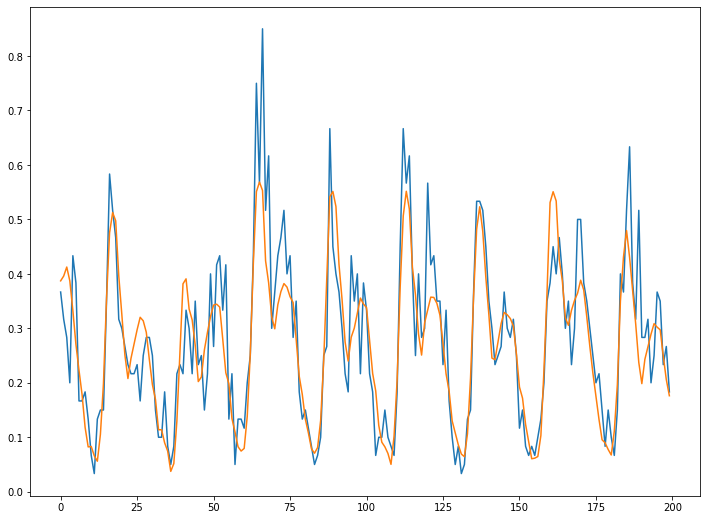

In [37]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2000, shuffle=False, drop_last=False)    
for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    
    plt.figure(figsize=(12,9))
    plt.plot(y[:200,1].cpu())
    plt.plot(y_pred[:200,1].detach().cpu())

    break

#### Compute MSE over prediction horizon
Note that the  model produces prediction for 72h into the future. The current loss minimizes the average means square error.<br>
In general, we expect the accuracy to drop as prediction range increases. 

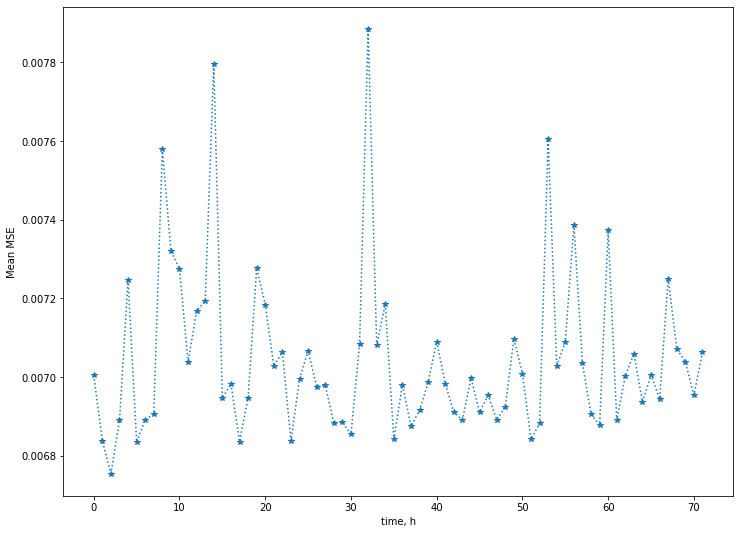

In [38]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2000, shuffle=False, drop_last=False)    
mse_t = torch.zeros(all_data.horizon_samples)
for (X, y) in test_loader:
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    
    mse_t += (y_pred-y).square().sum(dim=0).to("cpu").detach() # computes 72 values for accuracy, summed over the batch 
    
mse_t = mse_t / len(test_dataset)

plt.figure(figsize=(12,9))
plt.plot(mse_t, '*:')
plt.xlabel('time, h'); plt.ylabel('Mean MSE');

## Multichannel CNN

### dataset
#### Define Multichannel Dataset

In [39]:
class TimeSeriesMultichannelDataSet(torch.utils.data.Dataset):
    """Loads and provides access to MNIST Dataset"""
    
    def __init__(self, data_folder, history_samples, horizon_samples):
        import pandas as pd, os, torch, numpy as np
        super(TimeSeriesMultichannelDataSet).__init__() # call parent class constructor. 
        
        self.data_folder = data_folder
        self.history_samples = history_samples
        self.horizon_samples = horizon_samples
        
        self.df = pd.read_csv( os.path.join(self.data_folder, 'ER admission_1.csv') )
        self.df['t'] = pd.to_datetime(self.df['t'])
        self.df['weekday'] = self.df['t'].apply(lambda x: x.weekday())
        self.df['hour'] = self.df['t'].apply(lambda x: x.hour)
        
        holidays = pd.read_csv( os.path.join(self.data_folder, 'IsraeliHolidays.csv') )
        holidays['Date'] = pd.to_datetime(holidays['Date']).apply(lambda x: x.date())
        self.df['is_holiday'] = self.df['t'].apply(lambda x: x.date()).isin(holidays['Date']).astype(np.float32)
        
        self.df = self.df.reset_index(drop=True).set_index('t')        
        
        self.df = pd.get_dummies(self.df, columns=['weekday', 'hour'], dtype=np.float32)
        
        self.number_of_channels = self.df.shape[1] # number of columns. 

    def __len__(self):
        return len(self.df) - self.history_samples - self.horizon_samples + 1

    def __getitem__(self, idx):
        import torch
        if idx >= self.__len__():
            raise  IndexError(f'Index out of range: {idx} out of {self.__len__()}')
        x = torch.FloatTensor(self.df.iloc[idx:idx+ self.history_samples].values)
        y = torch.FloatTensor(self.df.iloc[idx+ self.history_samples : idx+self.history_samples + self.horizon_samples]['n'].values)
        return (x.transpose(-1,-2).unsqueeze(-3), y) # number of samples, number of channels
    

#### Load and scale the data 

In [52]:
all_data = TimeSeriesMultichannelDataSet(data_folder,
                history_samples=24*14, 
                horizon_samples=24*3)
# split into train and test set
train_dataset = torch.utils.data.Subset(all_data, list(range(int(len(all_data)*0.9))))
test_dataset = torch.utils.data.Subset(all_data, list(range(int(len(all_data)*0.9)+all_data.history_samples+all_data.horizon_samples, len(all_data))))
# normalize
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
# train scaler on the train set: 0 to len(train_set) + history_samples + horizon_samples
scaler.fit(all_data.df['n'].iloc[:len(train_dataset)+all_data.history_samples+all_data.horizon_samples].values.reshape(-1, 1) )
all_data.df['n'] = scaler.transform(all_data.df['n'].values.reshape(-1,1))

### Define 2d CNN 

In [67]:
class CNNModel1b(torch.nn.Module):
    def __init__(self, window_size,  input_dim, output_dim):
        super(CNNModel1b, self).__init__()
        self.window_size  = window_size # number of samples to train from. 
        self.input_dim = input_dim # number of features in the input. 
        self.output_dim = output_dim # number of features to predict. 

        # Define the Conv1 layer
        # batch_size x input_dim  x  336 -> batch_size x 25 x  336
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels= 25, kernel_size=[9,33], padding=[4,16])
        #self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels= 25, kernel_size=[33,9], padding=[16, 4])
        self.relu1 = torch.nn.ReLU()
        #self.bn1 = torch.nn.BatchNorm1d(25)
        # batch_size x 25 x  336 -> batch_size x 25 x  336/2
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=(2,2))
        #self.dropout1 = torch.nn.Dropout(0.3)
        
        # batch_size x 25 x  336/2 -> batch_size x 20 x  336/2=84
        self.conv2 = torch.nn.Conv2d( 25, 20, kernel_size=(5,5), padding=(2,2))
        self.relu2 = torch.nn.ReLU()
        #self.bn2 = torch.nn.BatchNorm1d(20)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=(2,2))
        
        # batch_size x 25 x  336/2 -> batch_size x 20 x  336/4=84
        #self.maxpool2 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        #self.dropout2 = torch.nn.Dropout(0.3)
        

        # Define the dense layers. 
        self.fc1 = torch.nn.Linear(20*int(self.window_size/4) *int(self.input_dim/4), 100)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(100, self.output_dim)

    def forward(self, x):
        #x shape: batch_size x input_dim x window_size
        if x.ndim == 3: 
            x = x.unsqueeze(0)
        batch_size = x.shape[0] # first dimension of the input is the number of batches. 
        #print(x.shape)
        x = self.relu1(self.conv1(x))     
        x = self.maxpool1(x)
        #print(x.shape)
        x = self.relu2(self.conv2(x))     
        x = self.maxpool1(x)
        #print(x.shape)
        x = self.relu1(self.fc1(x.view(batch_size,-1)))
        x = self.fc2(x)

        return x

#### Demonstrate use of the dataset

In [68]:
# all_data.number_of_channels = 33!
model = CNNModel1b(window_size=all_data.history_samples,  input_dim=all_data.number_of_channels, output_dim=all_data.horizon_samples)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=3, shuffle=True, drop_last=False)    
x, y = next(iter(train_loader))

x.shape,model(x).shape, y.shape

(torch.Size([3, 1, 33, 336]), torch.Size([3, 72]), torch.Size([3, 72]))

In [ ]:
checkpoint_file_name = os.path.join(data_folder, 'ER Admission - CNN -1b.checkpoint.pt' )
n_epochs = 15
batch_size = 200

model = CNNModel1b(window_size=all_data.history_samples,  input_dim=all_data.number_of_channels, output_dim=all_data.horizon_samples)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)


model, progress_log = training_loop(model, optimizer, criterion, device, train_dataset, validation_dataset=None, 
                    n_epochs = n_epochs, batch_size = batch_size, 
                    checkpoint_file_name=checkpoint_file_name) 

In [36]:
for log_entry in progress_log: 
    print(f"{log_entry['epoch']} of {len(progress_log)}. Loss: {log_entry['loss']:0.4f}.Train accuracy: {log_entry['train_accuracy'].item():0.4f}.")

0 of 15. Loss: 0.2045.Train accuracy: 0.0169.
1 of 15. Loss: 0.0142.Train accuracy: 0.0099.
2 of 15. Loss: 0.0095.Train accuracy: 0.0098.
3 of 15. Loss: 0.0092.Train accuracy: 0.0093.
4 of 15. Loss: 0.0092.Train accuracy: 0.0091.
5 of 15. Loss: 0.0091.Train accuracy: 0.0090.
6 of 15. Loss: 0.0090.Train accuracy: 0.0089.
7 of 15. Loss: 0.0089.Train accuracy: 0.0088.
8 of 15. Loss: 0.0089.Train accuracy: 0.0087.
9 of 15. Loss: 0.0088.Train accuracy: 0.0088.
10 of 15. Loss: 0.0087.Train accuracy: 0.0086.
11 of 15. Loss: 0.0085.Train accuracy: 0.0087.
12 of 15. Loss: 0.0085.Train accuracy: 0.0084.
13 of 15. Loss: 0.0084.Train accuracy: 0.0084.
14 of 15. Loss: 0.0083.Train accuracy: 0.0083.


In [20]:
import gc
del optimizer, model
gc.collect()
torch.cuda.empty_cache()